# Manifold Learning

Manifold learning is a set of techniques in machine learning and statistics for **non-linear dimensionality reduction**.
It assumes that high-dimensional data lies on a much lower-dimensional **manifold** embedded in the ambient space.

---

## 1. Intuition

- Real-world data is often **high-dimensional** (images, text embeddings, genomics, etc.).
- However, the **true degrees of freedom** are much smaller.
- Example: Handwritten digits live on a low-dimensional curved surface inside a high-dimensional pixel space.

---

## 2. Mathematical Definition

Let data points be:

$$
X = \{x_1, x_2, \dots, x_n\}, \quad x_i \in \mathbb{R}^D
$$

with a large ambient dimension \( D \).

We assume that data lies (approximately) on a smooth manifold:

$$
\mathcal{M} \subset \mathbb{R}^D, \quad \dim(\mathcal{M}) = d \ll D
$$

The goal is to find a mapping:

$$
f : \mathbb{R}^D \to \mathbb{R}^d
$$

such that local geometry (distances or neighborhoods) is preserved.

---

## 3. Distance Concepts

- **Euclidean distance (ambient space):**

$$
d_E(x_i, x_j) = \sqrt{ \sum_{k=1}^D (x_{ik} - x_{jk})^2 }
$$

- **Geodesic distance (manifold space):**
Distance measured **along the manifold** rather than through space.

$$
d_G(x_i, x_j) = \min_{\gamma} \int_0^1 \|\dot{\gamma}(t)\| \, dt
$$

where \( \gamma \) is a smooth path lying on the manifold connecting \(x_i\) and \(x_j\).

---

## 4. Classical Methods

### Principal Component Analysis (PCA)

- Finds a **linear subspace** of dimension \(d\).
- Works if the manifold is flat.
- Limitation: cannot capture curved manifolds.

### ISOMAP

- Builds a neighborhood graph of points.
- Estimates **geodesic distances** using shortest paths.
- Uses Multidimensional Scaling (MDS) for embedding.

### Locally Linear Embedding (LLE)

- Assumes each point can be reconstructed from its neighbors:

$$
x_i \approx \sum_{j \in \mathcal{N}(i)} w_{ij} x_j
$$

- In low dimension, the weights \( w_{ij} \) are preserved.

### t-SNE

- Converts pairwise distances into probability distributions.
- Minimizes Kullback–Leibler divergence between high- and low-dimensional distributions.

### UMAP

- Graph-based, preserving **topology and fuzzy set membership**.
- Faster and scales better than t-SNE.

---

## 5. Geometry View

A **manifold** has a tangent space at each point.
Linear methods (like PCA) approximate the manifold by one global tangent plane.
Nonlinear methods (Isomap, LLE, t-SNE, UMAP) approximate the manifold by stitching together **local tangent spaces**.

---

## 6. Applications

- **Visualization:** High-dimensional data → 2D/3D plots (t-SNE, UMAP).
- **Feature extraction:** Capture latent variables (pose, lighting, style).
- **Compression:** Reduce dimensionality for storage or computation.
- **Generative models:** Many assume that data lives on a manifold.

---

## 7. Key Takeaway

Manifold learning relies on the assumption:

$$
\text{High-dimensional data } \subset \text{ Low-dimensional manifold }
$$

The task is to **uncover this manifold** and represent data in fewer dimensions while preserving its **geometry** and **structure**.


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll
from sklearn.decomposition import PCA
from sklearn.manifold import LocallyLinearEmbedding,Isomap

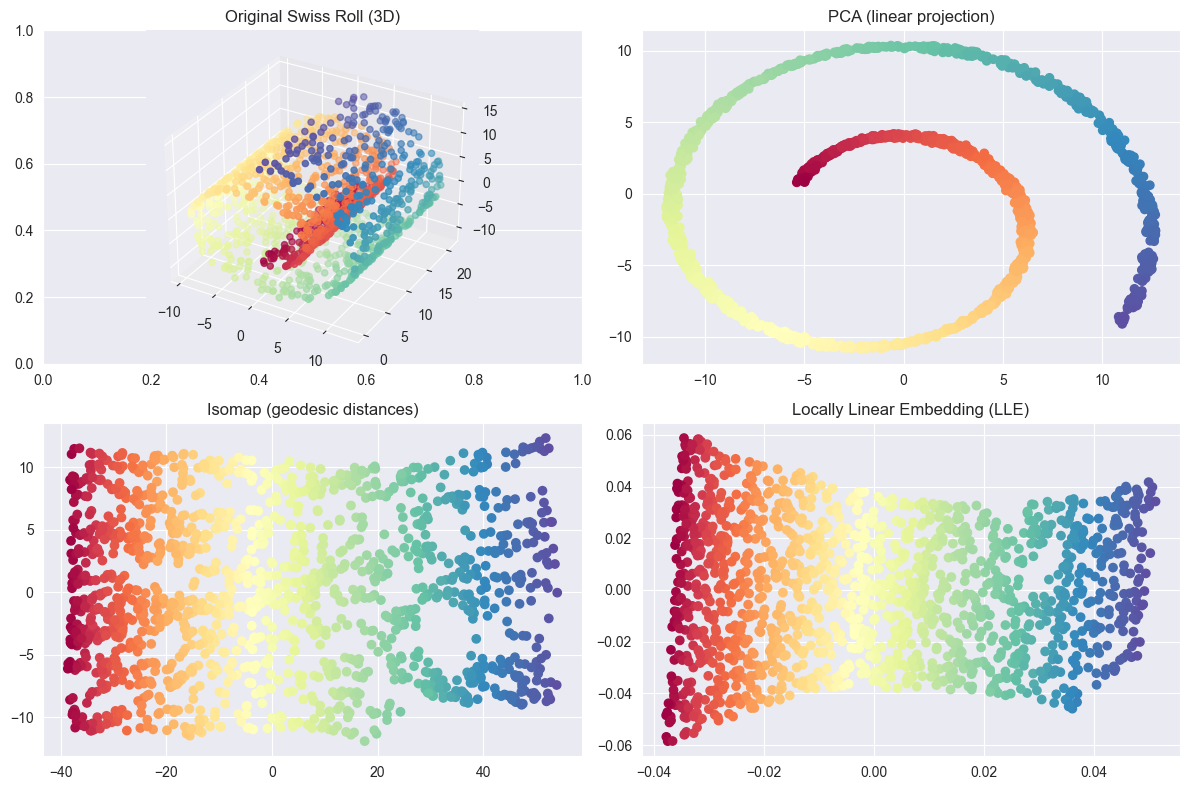

In [24]:
X,color=make_swiss_roll(n_samples=1500,noise=0.05,random_state=42)
pca=PCA(n_components=2)
x_pca=pca.fit_transform(X)

isomap=Isomap(n_neighbors=10,n_components=2)
x_isomap=isomap.fit_transform(X)

lle = LocallyLinearEmbedding(n_neighbors=10, n_components=2, method='standard')
X_lle = lle.fit_transform(X)
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

ax = fig.add_subplot(221, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.Spectral)
ax.set_title("Original Swiss Roll (3D)")

axs[0, 1].scatter(x_pca[:, 0], x_pca[:, 1], c=color, cmap=plt.cm.Spectral)
axs[0, 1].set_title("PCA (linear projection)")

axs[1, 0].scatter(x_isomap[:, 0], x_isomap[:, 1], c=color, cmap=plt.cm.Spectral)
axs[1, 0].set_title("Isomap (geodesic distances)")

# LLE embedding
axs[1, 1].scatter(X_lle[:, 0], X_lle[:, 1], c=color, cmap=plt.cm.Spectral)
axs[1, 1].set_title("Locally Linear Embedding (LLE)")

plt.tight_layout()
plt.show()

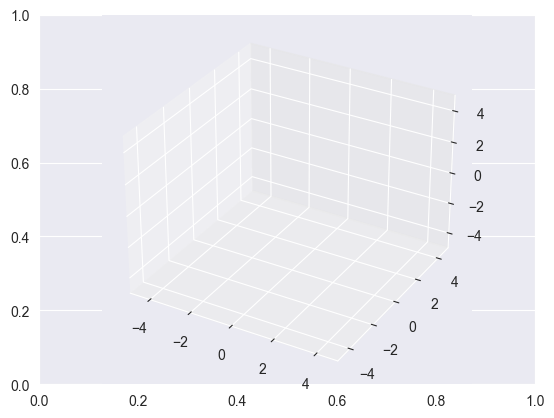

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

G = 1.0
N = 6
np.random.seed(0)
# Positions, velocities, masses
r = np.random.randn(N,3)
v = np.random.randn(N,3)*0.0
m = np.abs(np.random.randn(N)) + 0.5

dt, T = 0.002, 20.0
steps = int(T/dt)

def accel(r):
    a = np.zeros_like(r)
    for i in range(N):
        diff = r[i] - r
        dist3 = np.linalg.norm(diff, axis=1)**3 + 1e-3
        a[i] = -G * (m[:,None]*diff / dist3[:,None]).sum(axis=0)
    return a

# Leapfrog
R = []
a = accel(r)
for _ in range(steps):
    v += 0.5*dt*a
    r += dt*v
    a = accel(r)
    v += 0.5*dt*a
    R.append(r.copy())
R = np.array(R)  # [steps, N, 3]

fig = plt.subplots()[1]
ax = plt.axes(projection='3d')
ax.set_xlim(-5,5); ax.set_ylim(-5,5); ax.set_zlim(-5,5)
pts = ax.plot([], [], [], 'o')[0]
trails = [ax.plot([], [], [], '-', linewidth=0.75)[0] for _ in range(N)]
trail_len = 300

def init():
    pts.set_data([], []); pts.set_3d_properties([])
    for t in trails: t.set_data([], []); t.set_3d_properties([])
    return [pts, *trails]

def update(i):
    ri = R[i]
    pts.set_data(ri[:,0], ri[:,1]); pts.set_3d_properties(ri[:,2])
    j0 = max(0, i-trail_len)
    for k, t in enumerate(trails):
        seg = R[j0:i+1, k]
        t.set_data(seg[:,0], seg[:,1]); t.set_3d_properties(seg[:,2])
    return [pts, *trails]

ani = FuncAnimation(ax.figure, update, frames=len(R), init_func=init, interval=10, blit=True)
plt.show()
